![alt text](https://d18lkz4dllo6v2.cloudfront.net/cumulus_uploads/entry/32598/Americans%27%20favorite%20countries.jpg "Country Clusters")

# Country Clusters

Problema: Identificar países que necessitam de ajuda humanitária.
    
Solução: Agruparemos os países usando fatores socioeconômicos e de saúde para achar os que se encontram em situação difícil.

Os dados se encontram em https://www.kaggle.com/rohan0301/unsupervised-learning-on-country-data

In [1]:
from IPython.core.display import HTML
HTML(open('country_content.html', 'r').read())

<a id='libraries'></a>
<h2 style="color:DarkBlue" >Preparação do ambiente</h2>

Vamos baixar e importar as bibliotecas necessárias.

In [2]:
!pip install -q googletrans==4.0.0rc1
!pip install -U -q yellowbrick

In [3]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import sklearn

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans, Birch, MeanShift, AffinityPropagation, OPTICS, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score, silhouette_samples

import seaborn as sns

import matplotlib.cm as cm
from matplotlib import pyplot as plt

from yellowbrick.cluster import KElbowVisualizer

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from googletrans import Translator
from IPython.core.display import HTML

import warnings
warnings.filterwarnings('ignore')

In [4]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [5]:
sklearn.set_config(display='diagram')

<a id='load'></a>
<h2 style="color:DarkBlue" >Carregação dos dados</h2> 

In [6]:
raw_data = pd.read_csv('Country-data.csv')
raw_data

country  child_mort  exports  health  imports  income  \
0            Afghanistan        90.2     10.0    7.58     44.9    1610   
1                Albania        16.6     28.0    6.55     48.6    9930   
2                Algeria        27.3     38.4    4.17     31.4   12900   
3                 Angola       119.0     62.3    2.85     42.9    5900   
4    Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   
..                   ...         ...      ...     ...      ...     ...   
162              Vanuatu        29.2     46.6    5.25     52.7    2950   
163            Venezuela        17.1     28.5    4.91     17.6   16500   
164              Vietnam        23.3     72.0    6.84     80.2    4490   
165                Yemen        56.3     30.0    5.18     34.4    4480   
166               Zambia        83.1     37.0    5.89     30.9    3280   

     inflation  life_expec  total_fer   gdpp  
0         9.44        56.2       5.82    553  
1         4.49        76.3       1.65   4090  
2        16.10        76.5       2.89   4460  
3        22.40        60.1       6.16   3530  
4         1.44        76.8       2.13  12200  
..         ...         ...        ...    ...  
162       2.62        63.0       3.50   2970  
163      45.90        75.4       2.47  13500  
164      12.10        73.1       1.95   1310  
165      23.60        67.5       4.67   1310  
166      14.00        52.0       5.40   1460  

[167 rows x 10 columns]

In [7]:
column_meaning = pd.read_csv('data-dictionary.csv')
column_meaning.rename(columns={'Column Name': 'Column_Name'}, inplace=True)

In [8]:
translator = Translator()
column_meaning['Description_Translated'] = column_meaning['Description'].apply(translator.translate, src='en', dest='pt').apply(getattr, args=('text',)).str.replace(r'((?<=[.])(?=[^\s]))|((?<=[^\s])(?=[%]))', r' ', regex=True)

In [9]:
fig = go.Figure(data=[go.Table(
                header=dict(values=list(column_meaning.columns[:-1].tolist() + ['Descrição']),
                line_color='darkslategray',
                fill_color='gray',
                font=dict(color='white', size=12),
                align='left'),
                cells=dict(values=[column_meaning.Column_Name,
                                   column_meaning.Description,
                                   column_meaning.Description_Translated],
                line_color='darkslategray',
                fill_color='white',
                font = dict(color='darkslategray', size=11),
                align='left'))])

fig.update_layout(title_text='Descrição dos dados')
fig.show()

In [10]:
raw_data.dtypes

country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object

In [11]:
raw_data.describe()

child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167.000000     167.000000   
mean    38.270060   41.108976    6.815689   46.890215   17144.688623   
std     40.328931   27.412010    2.746837   24.209589   19278.067698   
min      2.600000    0.109000    1.810000    0.065900     609.000000   
25%      8.250000   23.800000    4.920000   30.200000    3355.000000   
50%     19.300000   35.000000    6.320000   43.300000    9960.000000   
75%     62.100000   51.350000    8.600000   58.750000   22800.000000   
max    208.000000  200.000000   17.900000  174.000000  125000.000000   

        inflation  life_expec   total_fer           gdpp  
count  167.000000  167.000000  167.000000     167.000000  
mean     7.781832   70.555689    2.947964   12964.155689  
std     10.570704    8.893172    1.513848   18328.704809  
min     -4.210000   32.100000    1.150000     231.000000  
25%      1.810000   65.300000    1.795000    1330.000000  
50%      5.390000   73.100000    2.410000    4660.000000  
75%     10.750000   76.800000    3.880000   14050.000000  
max    104.000000   82.800000    7.490000  105000.000000

In [12]:
raw_data.isna().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

O dataset não possui valores nulos.

<a id='helper_functions'></a>
<h2 style="color:DarkBlue" >Funções de ajuda</h2>

In [13]:
labels = {'country' : 'país',
          'child_mort': 'mort_inf',
          'exports': 'exportações',
          'health' : 'saúde',
          'imports' : 'importações',
          'income': 'renda',
          'inflation': 'inflação',
          'life_expec': 'expec_vida',
          'total_fer' : 'fert_total',
          'gdpp': 'pib'}

In [14]:
colorscale = ([[0, 'rgb(0,200,200)'], [0.0799, 'rgb(0,150,100)'], [0.08, 'rgb(245,230,0)'], [1, 'rgb(200,0,0)']],
              [[0, 'rgb(200,0,0)'], [0.18, 'rgb(245,230,0)'], [0.45, 'rgb(0,150,100)'], [1, 'rgb(0,200,200)']],
              [[0, 'rgb(200,0,0)'], [0.25, 'rgb(245,230,0)'], [0.5, 'rgb(0,170,170)'], [1, 'rgb(0,200,200)']],
              [[0, 'rgb(0,200,200)'], [0.31, 'rgb(235,230,0)'], [1, 'rgb(200,0,0)']],
              [[0, 'rgb(200,0,0)'], [0.15, 'rgb(245,230,0)'], [0.27, 'rgb(0,170,170)'], [1, 'rgb(0,200,200)']],
              [[0, 'rgb(0,200,200)'], [0.14, 'rgb(235,230,0)'], [1, 'rgb(200,0,0)']],
              [[0, 'rgb(200,0,0)'], [0.7, 'rgb(235,230,0)'], [1, 'rgb(0,200,200)']],
              [[0, 'rgb(200,0,0)'], [0.12, 'rgb(235,230,0)'], [0.38, 'rgb(0,160,160)'], [1, 'rgb(0,200,200)']],
              [[0, 'rgb(200,0,0)'], [0.11, 'rgb(235,230,0)'], [0.3, 'rgb(0,170,170)'], [1, 'rgb(0,200,200)']])

In [15]:
def plot_bar(df, column, title, colorscale):
    fig = px.bar(df.sort_values(by=column),
                 x=column,
                 y='country',
                 color=column,
                 labels=labels,
                 title=title)

    fig.update_layout(height=3000,
                      coloraxis=dict(cmin=df[column].min(),
                                     cmax=df[column].max(),
                                     colorscale=colorscale))
    fig.show()

In [16]:
def data_2d(df, cluster_method):
    def reduceDim(df):
        transformed_data_2d = TSNE(n_components=2, random_state=0).fit_transform(df)
        return pd.DataFrame(transformed_data_2d, columns=['x', 'y'], index=df.index)

    def concat(df, cluster_method):
        clusters = pd.DataFrame(cluster_method.labels_, columns=['cluster'], index=df.index)
        reduced = reduceDim(df.drop(columns=['country']))
        data = pd.concat([df, clusters, reduced], axis=1).sort_values(by='cluster')
        return data
    
    return concat(df, cluster_method)

In [17]:
def color_rgb(data):
    c = {data[data['country'] == 'Sweden']['cluster'].values[0].astype(str): 'rgb(0,204,150)',
         data[data['country'] == 'Brazil']['cluster'].values[0].astype(str): 'rgb(0,0,230)',
         data[data['country'] == 'Haiti']['cluster'].values[0].astype(str): 'rgb(230,0,0)'}
    return c

def plot2d(data2d, title):
    fig = px.scatter(data2d,
                     x='x',
                     y='y',
                     labels=labels,
                     title=title,
                     color=data2d.cluster.astype(str),
                     color_discrete_map=color_rgb(data2d),
                     hover_name=data2d.country,
                     hover_data={'x': False,
                                 'y': False})

    fig.update_traces(marker=dict(size=9,
                                  line=dict(width=1,
                                            color='DarkSlateGrey')),
                      selector=(dict(mode='markers')),
                      hovertemplate='<b>%{hovertext}</b><extra></extra>')

    fig.update_layout(legend=dict(title='cluster'))
    fig.show()
    
def plot2x2d(data, title):
    fig1 = make_subplots(rows=2, cols=1)
    for i in range(2): 
        fig = px.scatter(data[i],
                         x='x',
                         y='y',
                         labels=labels,
                         title='Clusters',
                         color=data[i].cluster.astype(str),
                         color_discrete_map=color_rgb(data[i]),
                         hover_name=data[i].country,
                         hover_data={'x': False,
                                     'y': False})

        fig.update_traces(marker=dict(size=9,
                                      line=dict(width=1,
                                                color='DarkSlateGrey')),
                          selector=(dict(mode='markers')),
                          hovertemplate='<b>%{hovertext}</b><extra></extra>')

        for t in fig.data:
            fig1.add_trace(t, row=i+1, col=1)

    for i in range(3):
        fig1.data[i].showlegend = False

    fig1.update_layout(title=dict(text=title),
                       legend=dict(title='cluster', tracegroupgap=1))
    fig1.show()

<a id='eda'></a>
<h2 style="color:DarkBlue" >Análise exploratória</h2> 

In [18]:
plot_bar(raw_data, 'child_mort', 'Mortalidade infantil', colorscale[0])

In [19]:
plot_bar(raw_data, 'exports', 'Exportações', colorscale[1])

Interessante observar que Brasil está entre as últimas colocações.

In [20]:
plot_bar(raw_data, 'health', 'Saúde', colorscale[2])

In [21]:
plot_bar(raw_data, 'imports', 'Importações', colorscale[3])

In [22]:
plot_bar(raw_data, 'income', 'Renda', colorscale[4])

In [23]:
plot_bar(raw_data, 'inflation', 'Inflação', colorscale[5])

In [24]:
plot_bar(raw_data, 'life_expec', 'Expectativa de vida', colorscale[6])

In [25]:
plot_bar(raw_data, 'total_fer', 'Fertilidade total', colorscale[7])

In [26]:
plot_bar(raw_data, 'gdpp', 'PIB', colorscale[8])

In [27]:
titles = [labels[col_name] for col_name in raw_data.columns]
names = [col_name for col_name in raw_data.columns]
fig1 = make_subplots(rows=3, cols=3, subplot_titles=titles[1:])
k = 1

for i in range(3):
    for j in range(3):       
        fig2 = go.Box(x=raw_data[names[k]],
                     name='',
                     hovertext=raw_data['country'],
                     hovertemplate='<b>%{hovertext}</b><br><br>%{x}<extra></extra>',
                     showlegend=False)            
        fig1.add_trace(fig2, row=i+1, col=j+1)
        k += 1

for i in range(len(raw_data.columns)-1):
    fig1.layout.annotations[i].font = dict(size=15)
        
fig3 = go.Figure(fig1)
fig3.update_layout(title_text='Outliers')
fig3.show()

Nota-se que o dataset possui uma quantidade razoável de outliers. Não vamos retirá-los pois estaríamos perdendo os países que precisam de ajuda humanitária.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


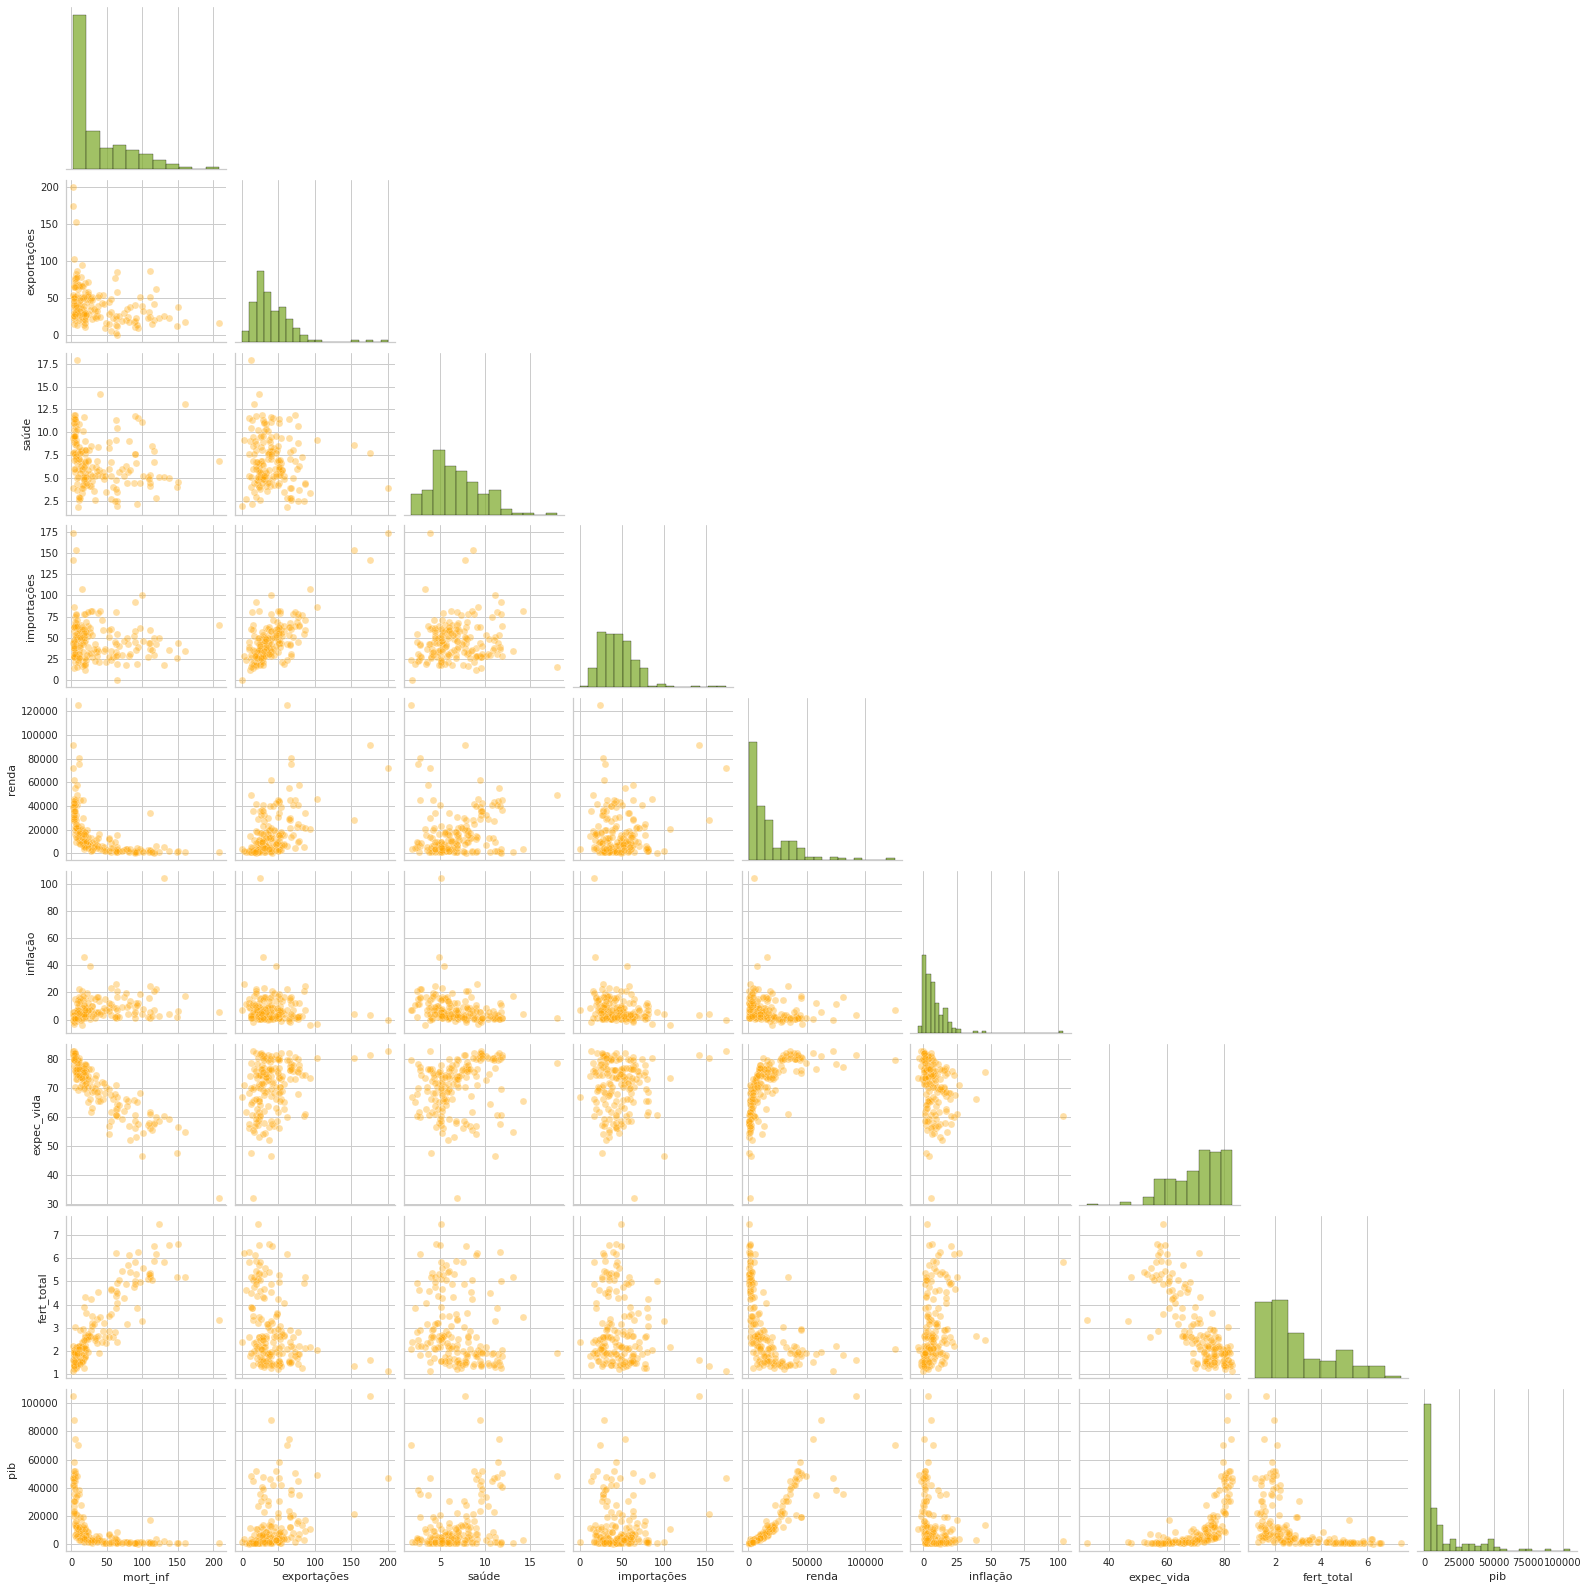

In [28]:
sns.pairplot(raw_data.rename(columns=labels),
             corner=True,
             plot_kws=dict(color='#FFA500',
                           alpha=0.35),
             diag_kws=dict(color='#82ad32'));

In [29]:
def heatmap(data, method, labels):
    sns.set(style="white")
    corr = data.corr(method=method)
    corr.index = corr.columns = pd.Index(labels)

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 11))
    ax.set_title('Correlação ' + method, y=1.02, fontsize=16)
    ax.tick_params(axis='x', rotation=45)
    sns_plot = sns.heatmap(corr, mask=mask, annot=True, center=0, square=True, fmt=".2f", linewidths=.5, cmap=sns.diverging_palette(10, 150, as_cmap=True))
    plt.show()

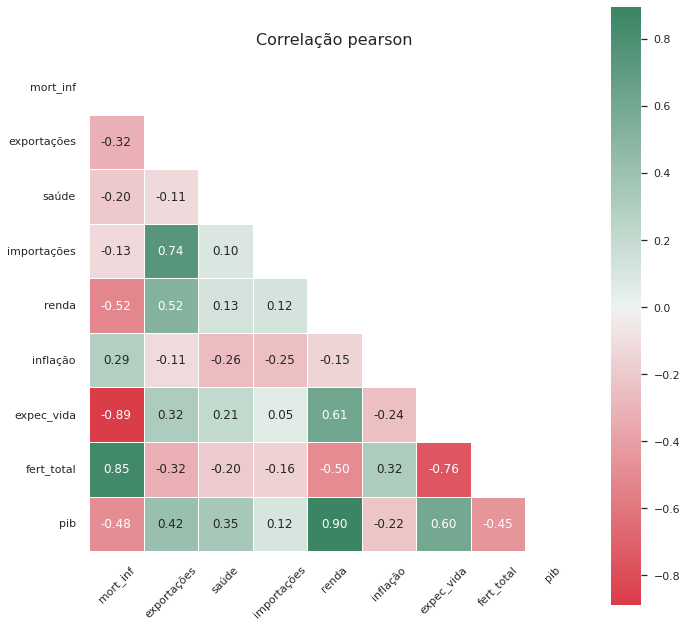

In [30]:
heatmap(data=raw_data, method='pearson', labels=titles[1:])

Percebe-se uma forte correlação entre importações e exportações, assim como PIB e renda. Nos países com maior taxa de fertilidade, a expectativa de vida é menor e a mortalidade infantil é maior. A renda apresenta uma boa correlação com o número de exportações.

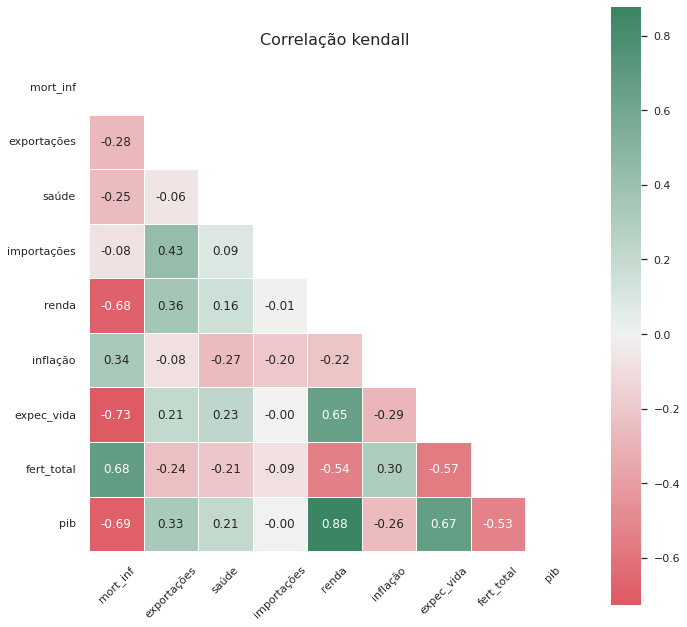

In [31]:
heatmap(data=raw_data, method='kendall', labels=titles[1:])

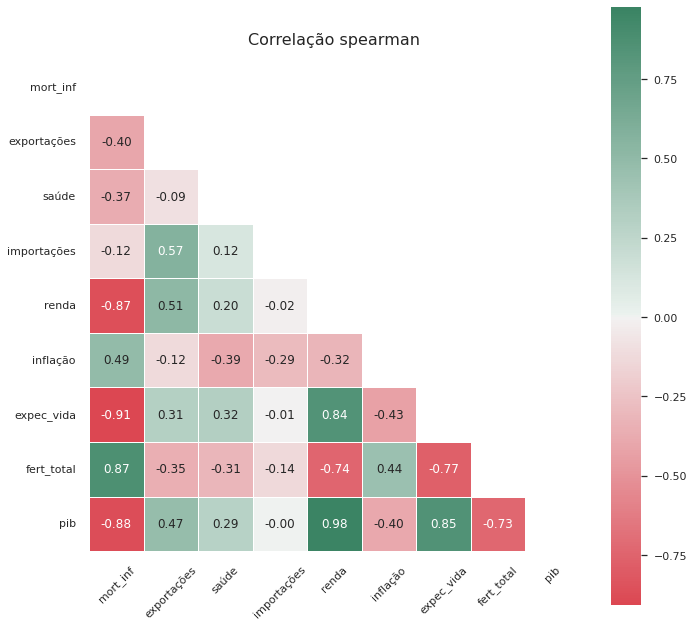

In [32]:
heatmap(data=raw_data, method='spearman', labels=titles[1:])

As correlações Kendall e Spearman confirmam os resultados.

<a id='h_cluster'></a>
<h2 style="color:DarkBlue" >Cluster Hierárquico</h2> 

In [33]:
fig = ff.create_dendrogram(raw_data.drop(columns=['country']), orientation='left', labels=raw_data['country'].values)
fig.update_layout(width=800, height=2500, font_size=11, title_text='Cluster Hieráquico')
fig.show()

Podemos ver 3 clusters principais que contem países como:
* Quatar, Luxembourg, Norway, Switzerland.
* Equatorial Guinea, Libya, Kazakhstan, Malaysia, Russia.
* Singapore, Brunei, Kuwait, Austria.

O cluster que contém o país Quatar parece ser uma excessão. Para evitar isso, vamos trocar a função de ligação para ward.

In [34]:
fig = ff.create_dendrogram(raw_data.drop(columns=['country']),
                           orientation='left',
                           labels=raw_data['country'].values,
                           linkagefun=lambda x: sch.linkage(x, 'ward'))
fig.update_layout(width=800, height=2500, font_size=11, title_text='Cluster Hieráquico com ligação ward')
fig.show()

Os 3 clusters melhoraram. Mais a ligações entre os países estão um pouco estranhas. Vamos normalizar os dados com MinMaxScaler e ver o que acontece.

In [35]:
def scaler(data, scl):
    data_norm = scl().fit_transform(data.drop(columns=['country']))
    data_norm_full = pd.concat([data['country'], pd.DataFrame(data_norm, columns=names[1:])], axis=1)
    return data_norm_full

In [36]:
min_max_data = scaler(raw_data, MinMaxScaler)
min_max_data

country  child_mort   exports    health   imports    income  \
0            Afghanistan    0.426485  0.049482  0.358608  0.257765  0.008047   
1                Albania    0.068160  0.139531  0.294593  0.279037  0.074933   
2                Algeria    0.120253  0.191559  0.146675  0.180149  0.098809   
3                 Angola    0.566699  0.311125  0.064636  0.246266  0.042535   
4    Antigua and Barbuda    0.037488  0.227079  0.262275  0.338255  0.148652   
..                   ...         ...       ...       ...       ...       ...   
162              Vanuatu    0.129503  0.232582  0.213797  0.302609  0.018820   
163            Venezuela    0.070594  0.142032  0.192666  0.100809  0.127750   
164              Vietnam    0.100779  0.359651  0.312617  0.460715  0.031200   
165                Yemen    0.261441  0.149536  0.209447  0.197397  0.031120   
166               Zambia    0.391918  0.184556  0.253574  0.177275  0.021473   

     inflation  life_expec  total_fer      gdpp  
0     0.126144    0.475345   0.736593  0.003073  
1     0.080399    0.871795   0.078864  0.036833  
2     0.187691    0.875740   0.274448  0.040365  
3     0.245911    0.552268   0.790221  0.031488  
4     0.052213    0.881657   0.154574  0.114242  
..         ...         ...        ...       ...  
162   0.063118    0.609467   0.370662  0.026143  
163   0.463081    0.854043   0.208202  0.126650  
164   0.150725    0.808679   0.126183  0.010299  
165   0.257000    0.698225   0.555205  0.010299  
166   0.168284    0.392505   0.670347  0.011731  

[167 rows x 10 columns]

In [37]:
fig = ff.create_dendrogram(min_max_data.drop(columns=['country']),
                           orientation='left',
                           labels=min_max_data['country'].values,
                           linkagefun=lambda x: sch.linkage(x, 'ward'))
fig.update_layout(width=800, height=2500, font_size=11, title_text='Cluster Hieráquico com normalização MinMaxScaler')
fig.show()

Ficou mais razoável. Interessante ver que há similaridade entre Brasil e Argentina. E se normalizarmos com RobustScaler?

In [38]:
robust_data = scaler(raw_data, RobustScaler)
robust_data

country  child_mort   exports    health   imports    income  \
0            Afghanistan    1.316620 -0.907441  0.342391  0.056042 -0.429416   
1                Albania   -0.050139 -0.254083  0.062500  0.185639 -0.001543   
2                Algeria    0.148561  0.123412 -0.584239 -0.416813  0.151196   
3                 Angola    1.851439  0.990926 -0.942935 -0.014011 -0.208794   
4    Antigua and Barbuda   -0.167131  0.381125 -0.078804  0.546410  0.470044   
..                   ...         ...       ...       ...       ...       ...   
162              Vanuatu    0.183844  0.421053 -0.290761  0.329247 -0.360504   
163            Venezuela   -0.040854 -0.235935 -0.383152 -0.900175  0.336333   
164              Vietnam    0.074280  1.343013  0.141304  1.292469 -0.281306   
165                Yemen    0.687094 -0.181488 -0.309783 -0.311734 -0.281821   
166               Zambia    1.184773  0.072595 -0.116848 -0.434326 -0.343533   

     inflation  life_expec  total_fer      gdpp  
0     0.453020   -1.469565   1.635492 -0.322877  
1    -0.100671    0.278261  -0.364508 -0.044811  
2     1.197987    0.295652   0.230216 -0.015723  
3     1.902685   -1.130435   1.798561 -0.088836  
4    -0.441834    0.321739  -0.134293  0.592767  
..         ...         ...        ...       ...  
162  -0.309843   -0.878261   0.522782 -0.132862  
163   4.531320    0.200000   0.028777  0.694969  
164   0.750559    0.000000  -0.220624 -0.263365  
165   2.036913   -0.486957   1.083933 -0.263365  
166   0.963087   -1.834783   1.434053 -0.251572  

[167 rows x 10 columns]

In [39]:
fig = ff.create_dendrogram(robust_data.drop(columns=['country']),
                           orientation='left',
                           labels=robust_data['country'].values,
                           linkagefun=lambda x: sch.linkage(x, 'ward'))
fig.update_layout(width=800, height=2500, font_size=11, title_text='Cluster Hieráquico com normalização RobustScaler')
fig.show()

Argentina está mais próxima de países como Russia e Irã. Já o Brasil, de Colombia, Turquia e Uruguai. A troca da normalização parece ter mudado consideravelmente os clusters. Vamos ver de quanto foi isso usando a métrica [Rand index](https://scikit-learn.org/stable/modules/clustering.html#rand-score).

In [40]:
agg_clustering_min_max = AgglomerativeClustering(linkage='ward', n_clusters=3)
agg_clustering_min_max.fit(min_max_data.drop(columns=['country']))

AgglomerativeClustering(n_clusters=3)

In [41]:
data_agg_min_max = data_2d(min_max_data, agg_clustering_min_max)

In [42]:
agg_clustering_robust = AgglomerativeClustering(linkage='ward',n_clusters=3)
agg_clustering_robust.fit(robust_data.drop(columns=['country']))

AgglomerativeClustering(n_clusters=3)

In [43]:
data_agg_robust = data_2d(min_max_data, agg_clustering_robust)

In [44]:
adjusted_rand_score(agg_clustering_min_max.labels_, agg_clustering_robust.labels_)

0.6855801769013901

É uma diferença razoável. Quais são os países que estão agupados diferentes?

In [45]:
raw_data[agg_clustering_min_max.labels_ != agg_clustering_robust.labels_]

country  child_mort  exports  health   imports  income  \
3                   Angola       119.0   62.300    2.85   42.9000    5900   
10                 Bahamas        13.8   35.000    7.89   43.7000   22900   
38             Congo, Rep.        63.9   85.100    2.46   54.7000    5190   
42                  Cyprus         3.6   50.200    5.97   57.5000   33900   
49       Equatorial Guinea       111.0   85.800    4.48   58.9000   33700   
50                 Eritrea        55.2    4.790    2.66   23.3000    1420   
72                    Iraq        36.9   39.400    8.41   34.1000   12700   
81                Kiribati        62.7   13.300   11.30   79.9000    1730   
84                     Lao        78.9   35.400    4.47   49.3000    3980   
87                 Lesotho        99.7   39.400   11.10  101.0000    2380   
88                 Liberia        89.3   19.100   11.80   92.6000     700   
99              Mauritania        97.4   50.700    4.41   61.2000    3320   
101  Micronesia, Fed. Sts.        40.0   23.500   14.20   81.0000    3340   
107                Myanmar        64.4    0.109    1.97    0.0659    3720   
116               Pakistan        92.1   13.500    2.20   19.4000    4280   
126                 Rwanda        63.6   12.000   10.50   30.0000    1350   
138            South Korea         4.1   49.400    6.93   46.2000   30400   
154           Turkmenistan        62.0   76.300    2.50   44.5000    9940   

     inflation  life_expec  total_fer   gdpp  
3       22.400        60.1       6.16   3530  
10      -0.393        73.8       1.86  28000  
38      20.700        60.4       4.95   2740  
42       2.010        79.9       1.42  30800  
49      24.900        60.9       5.21  17100  
50      11.600        61.7       4.61    482  
72      16.600        67.2       4.56   4500  
81       1.520        60.7       3.84   1490  
84       9.200        63.8       3.15   1140  
87       4.150        46.5       3.30   1170  
88       5.470        60.8       5.02    327  
99      18.900        68.2       4.98   1200  
101      3.800        65.4       3.46   2860  
107      7.040        66.8       2.41    988  
116     10.900        65.3       3.85   1040  
126      2.610        64.6       4.51    563  
138      3.160        80.1       1.23  22100  
154      2.310        67.9       2.83   4440

Melhor plotarmos um gráfico para entendermos a razão disso estar acontecendo.

In [46]:
data = (data_agg_min_max, data_agg_robust)
plot2x2d(data, 'Cluster Hieráquico MinMaxScaler vs RobustScaler')

Pelos gráficos, notamos que a normalização MinMaxScaler apresenta resultados melhores, pois países como Angola, Congo e alguns outros pertecem ao mesmo cluster, diferente do que ocorre ao aplicarmos RobustScaler.

<a id='k_means'></a>
<h2 style="color:DarkBlue" >K-means</h2> 

Vamos exibir o gráfico Elbow para sabermos a quantidade ideal que devemos escolher de clusters.

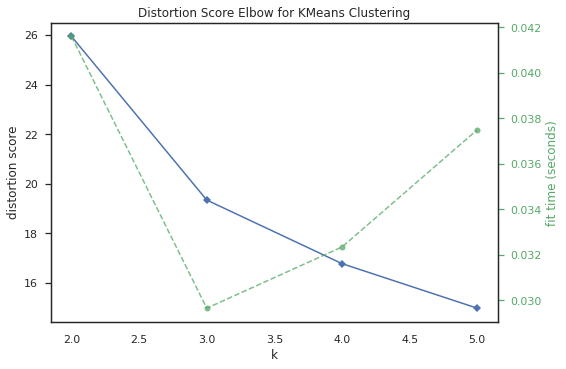

In [47]:
kmeans = KMeans(n_clusters=2, random_state=0)
visualize = KElbowVisualizer(kmeans, k=(2, 6))
visualize.fit(min_max_data.drop(columns=['country']))
visualize.poof()
plt.show()

Com os dados normalizados com MinMaxScaler o valor não foi encontrado. E com RobustScaler?

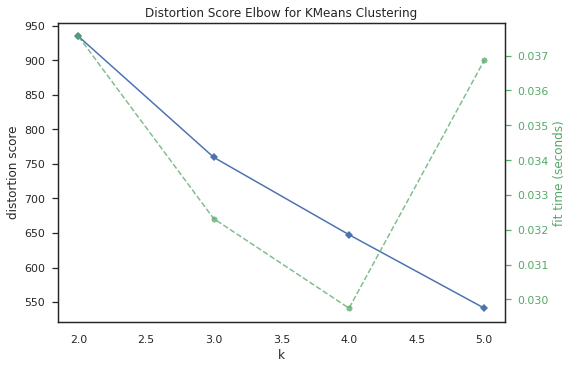

In [48]:
kmeans = KMeans(n_clusters=2, random_state=0)
visualize = KElbowVisualizer(kmeans, k=(2, 6))
visualize.fit(robust_data.drop(columns=['country']))
visualize.poof()
plt.show()

Também não. Havíamos visto na matriz de confusão que os atributos importações e exportações apresentam uma forte correlação. Vamos tirá-los para ver se esta é causa do problema.

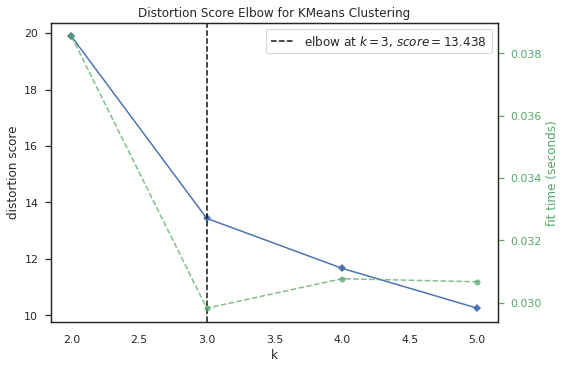

In [49]:
kmeans = KMeans(n_clusters=2, random_state=0)
visualize = KElbowVisualizer(kmeans, k=(2, 6))
visualize.fit(min_max_data.drop(columns=['country', 'imports', 'exports']))
visualize.poof()
plt.show()

Era realmente isso. O número ideal de clusters é 3.

Vamos observar se a pontução da silhueta confirma esse resultado.

Para n_clusters = 2 , a média da silhouette_score é : 0.384471920619431
Para n_clusters = 3 , a média da silhouette_score é : 0.33925909904021984
Para n_clusters = 4 , a média da silhouette_score é : 0.34967581498248707
Para n_clusters = 5 , a média da silhouette_score é : 0.2576268036422514
Para n_clusters = 6 , a média da silhouette_score é : 0.2565920076928669


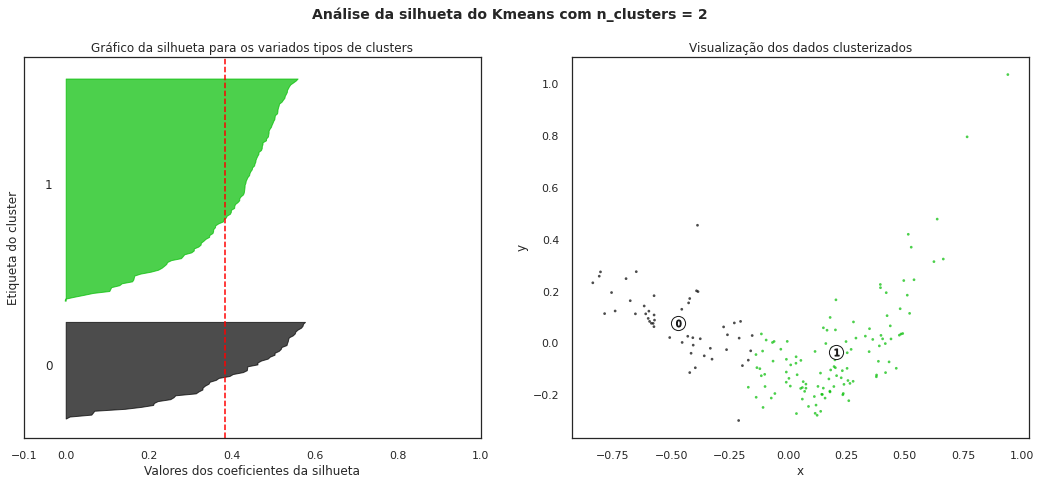

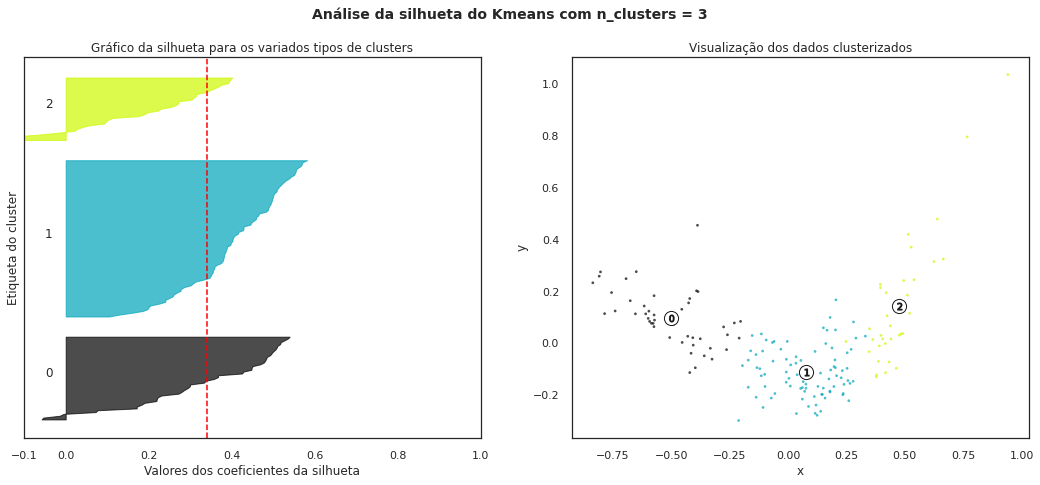

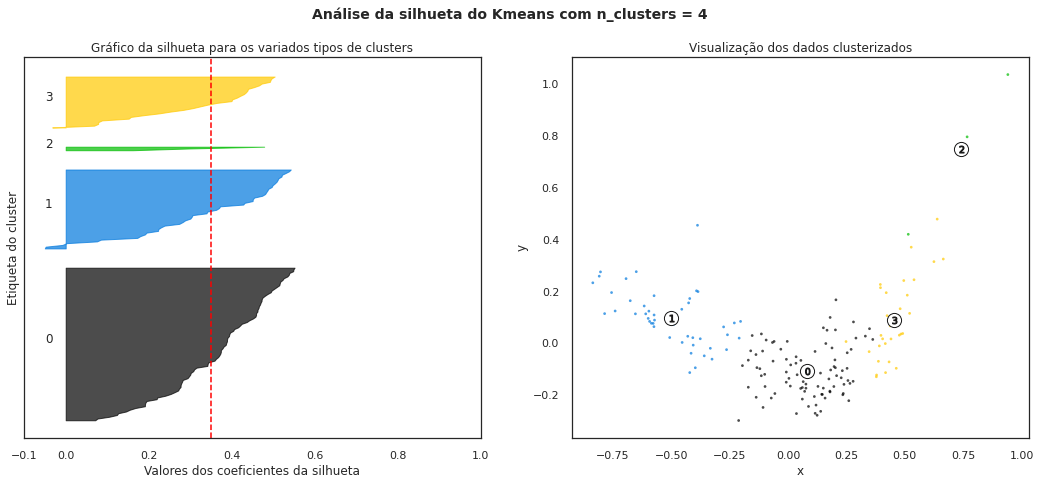

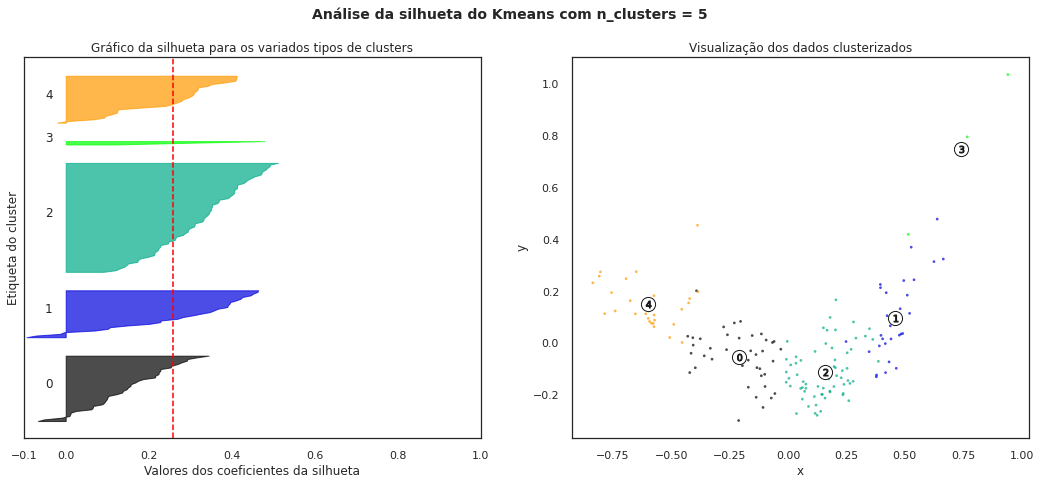

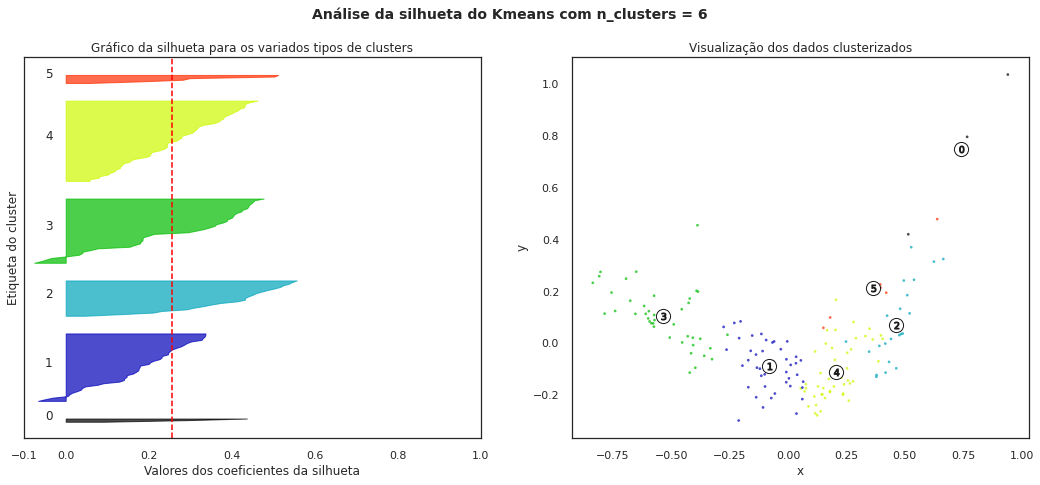

In [50]:
X = min_max_data.drop(columns=['country'])
pca = PCA(n_components=2)
pca.fit(X)
d2d = pca.transform(X)
range_n_clusters = np.arange(2, 7)

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print('Para n_clusters =', n_clusters,
          ', a média da silhouette_score é :', silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title('Gráfico da silhueta para os variados tipos de clusters')
    ax1.set_xlabel('Valores dos coeficientes da silhueta')
    ax1.set_ylabel('Etiqueta do cluster')

    ax1.axvline(x=silhouette_avg, color='red', linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(d2d[:, 0], d2d[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = pca.transform(clusterer.cluster_centers_)
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c='white', alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title('Visualização dos dados clusterizados')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')

    plt.suptitle(('Análise da silhueta do Kmeans '
                  'com n_clusters = %d' % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()

Vemos que 2 clusters possuem a melhor pontuação. Mas acreditamos que 3 clusters seja mais compatível com o nosso problema.

In [51]:
kmeans_min_max = KMeans(n_clusters=3, random_state=0)
kmeans_min_max.fit(min_max_data.drop(columns=['country']))

KMeans(n_clusters=3, random_state=0)

In [52]:
data_kmeans_min_max = data_2d(min_max_data, kmeans_min_max)

In [53]:
kmeans_robust = KMeans(n_clusters=3, random_state=0)
kmeans_robust.fit(robust_data.drop(columns=['country']))

KMeans(n_clusters=3, random_state=0)

In [54]:
data_kmeans_robust = data_2d(min_max_data, kmeans_robust)

In [55]:
adjusted_rand_score(kmeans_min_max.labels_, kmeans_robust.labels_)

0.7311459321804925

MinMaxScaler e RobustScaler agrupa uma parte dos países de forma diferente. Será exibido um gráfico para melhor observamos isso.

In [56]:
data = (data_kmeans_min_max, data_kmeans_robust)
plot2x2d(data, 'Kmeans MinMaxScaler vs RobustScaler')

É uma decisão difícil. K-means com RobustScaler considera mais países ao cluster 2, mas países como Índia e África do Sul não deveriam pertencer a este grupo. Só com mais métricas podemos comparar qual é o melhor.

<a id='pca'></a>
<h2 style="color:DarkBlue" >Redução de dimensionalidade</h2> 

Observaremos se a redução de dimensionalidade pode melhorar os algoritmos de clustering.

In [57]:
pca = PCA(n_components=9)
pca.fit(min_max_data.drop(columns=['country']))

PCA(n_components=9)

In [58]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

fig1 = px.line(x=range(1, exp_var_cumul.shape[0] + 1),
               y=exp_var_cumul)

fig2 = px.scatter(x=range(1, exp_var_cumul.shape[0] + 1),
                  y=exp_var_cumul,
                  labels={'x': 'Componentes', 'y': 'Variância'})

fig3 = go.Figure(data=fig1.data + fig2.data)
fig3.update_layout(title_text='Variância explicada vs Componentes',
                   xaxis_title='Número de componentes',
                   yaxis_title='Variância')
fig3.show()

Os primeiros 6 componentes explicam 97% da variância.

In [59]:
data = min_max_data.drop(columns=['country'])

dimensions = ['Dimension {}'.format(i) for i in range(1, len(pca.components_) + 1)]

components = pd.DataFrame(np.round(pca.components_, 4), columns = list(data.keys()))
components.index = dimensions

ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
variance_ratios.index = dimensions

In [60]:
plt_titles = ['Ve=%.4f'%(ev) for ev in pca.explained_variance_ratio_]
lbls = [labels[l] for l in components.columns]
num_cols = len(components.index)

fig1 = make_subplots(rows=1, cols=num_cols, y_title='Peso', subplot_titles=plt_titles, shared_yaxes=True)

for i in range(num_cols): 
    fig2 = px.bar(y=components.iloc[i],
                  color=lbls)
    
    for k, t in enumerate(fig2.data):
        t.hovertemplate = '<b>{}</b><br><br>'.format(lbls[k]) + '%{y}<extra></extra>'
        fig1.add_trace(t, row=1, col=i+1)
    
    fig1.layout['xaxis' + str(i+1)].showticklabels = False
    fig1.layout['xaxis' + str(i+1)].title = 'Dimensão ' +  str(i+1)

fig1.update_traces(width=1, showlegend=False)
for i in range(len(components.columns)):
    fig1.data[i].showlegend = True
    fig1.layout.annotations[i].font = dict(size=15)

fig1.update_layout(title=dict(text='Pesos dos atributos em cada dimensão da transformação PCA e a Variância explicada (Ve)'),
                   legend=dict(title='Atributos', tracegroupgap=1))

fig1.show()    

Serão mantidos os 6 componentes.

Analisaremos se o PCA ajuda o K-means com a normalização MinMaxScaler.

In [61]:
pca = PCA(n_components=6)
pca.fit(min_max_data.drop(columns=['country']))
data_pca = pca.transform(min_max_data.drop(columns=['country']))

In [62]:
kmeans_normal = KMeans(n_clusters=3, random_state=0)
kmeans_normal.fit(min_max_data.drop(columns=['country']))

kmeans_pca = KMeans(n_clusters=3, random_state=0)
kmeans_pca.fit(data_pca)

KMeans(n_clusters=3, random_state=0)

In [63]:
adjusted_rand_score(kmeans_normal.labels_, kmeans_pca.labels_)

1.0

Nenhuma diferença.

Com RobustScaler:

In [64]:
pca = PCA(n_components=6)
pca.fit(robust_data.drop(columns=['country']))
data_pca = pca.transform(robust_data.drop(columns=['country']))

In [65]:
kmeans_normal = KMeans(n_clusters=3, random_state=0)
kmeans_normal.fit(robust_data.drop(columns=['country']))

kmeans_pca = KMeans(n_clusters=3, random_state=0)
kmeans_pca.fit(data_pca)

KMeans(n_clusters=3, random_state=0)

In [66]:
adjusted_rand_score(kmeans_normal.labels_, kmeans_pca.labels_)

0.9587087831692866

Bem pouca diferença. Quais são os países que mudaram? 

In [67]:
robust_data[kmeans_normal.labels_ != kmeans_pca.labels_]

country  child_mort  exports    health   imports    income  inflation  \
21   Botswana    0.616527  0.31216  0.538043  0.280210  0.171767   0.394855   
108   Namibia    0.681523  0.46461  0.125000  0.609457 -0.077141  -0.204698   

     life_expec  total_fer      gdpp  
21    -1.391304   0.225420  0.132862  
108   -1.260870   0.570743  0.041667

In [68]:
data = (data_2d(robust_data, kmeans_normal), data_2d(robust_data, kmeans_pca))
plot2x2d(data, 'Kmeans RobustScaler sem e com PCA')

Agora o Cluster Hierárquico com MinMaxScaler:

In [69]:
pca = PCA(n_components=6)
pca.fit(min_max_data.drop(columns=['country']))
data_pca = pca.transform(min_max_data.drop(columns=['country']))

In [70]:
agg_clustering_normal = AgglomerativeClustering(linkage='ward', n_clusters=3)
agg_clustering_normal.fit(min_max_data.drop(columns=['country']))

agg_clustering_pca = AgglomerativeClustering(linkage='ward', n_clusters=3)
agg_clustering_pca.fit(data_pca)

AgglomerativeClustering(n_clusters=3)

In [71]:
adjusted_rand_score(agg_clustering_normal.labels_, agg_clustering_pca.labels_)

0.9040835921078809

In [72]:
min_max_data[agg_clustering_normal.labels_ != agg_clustering_pca.labels_]

country  child_mort   exports    health   imports    income  \
72           Iraq    0.166991  0.196562  0.410193  0.195672  0.097202   
84            Lao    0.371470  0.176551  0.165320  0.283062  0.027100   
107       Myanmar    0.300876  0.000000  0.009944  0.000000  0.025010   
126        Rwanda    0.296981  0.059487  0.540087  0.172100  0.005957   
154  Turkmenistan    0.289192  0.381163  0.042884  0.255465  0.075013   

     inflation  life_expec  total_fer      gdpp  
72    0.192311    0.692308   0.537855  0.040747  
84    0.123926    0.625247   0.315457  0.008676  
107   0.103965    0.684418   0.198738  0.007225  
126   0.063026    0.641026   0.529968  0.003169  
154   0.060253    0.706114   0.264984  0.040174

In [73]:
data = (data_2d(min_max_data, agg_clustering_normal), data_2d(min_max_data, agg_clustering_pca))
plot2x2d(data, 'Cluster Hierárquico MinMaxScaler sem e com PCA')

Também não mudou muito.

Com RobustScaler:

In [74]:
pca = PCA(n_components=6)
pca.fit(robust_data.drop(columns=['country']))
data_pca = pca.transform(robust_data.drop(columns=['country']))

In [75]:
agg_clustering_normal = AgglomerativeClustering(linkage='ward', n_clusters=3)
agg_clustering_normal.fit(robust_data.drop(columns=['country']))

agg_clustering_pca = AgglomerativeClustering(linkage='ward', n_clusters=3)
agg_clustering_pca.fit(data_pca)

AgglomerativeClustering(n_clusters=3)

In [76]:
adjusted_rand_score(agg_clustering_normal.labels_, agg_clustering_pca.labels_)

0.41117604209998565

Mudou bastante!

In [77]:
raw_data[agg_clustering_normal.labels_ != agg_clustering_pca.labels_]

country  child_mort  exports  health   imports  income  \
2                  Algeria        27.3   38.400    4.17   31.4000   12900   
3                   Angola       119.0   62.300    2.85   42.9000    5900   
5                Argentina        14.5   18.900    8.10   16.0000   18700   
9               Azerbaijan        39.2   54.300    5.88   20.7000   16000   
11                 Bahrain         8.6   69.500    4.97   50.9000   41100   
12              Bangladesh        49.4   16.000    3.52   21.8000    2440   
19                 Bolivia        46.6   41.200    4.84   34.3000    5410   
23                  Brunei        10.5   67.400    2.84   28.0000   80600   
38             Congo, Rep.        63.9   85.100    2.46   54.7000    5190   
42                  Cyprus         3.6   50.200    5.97   57.5000   33900   
47                   Egypt        29.1   21.300    4.66   26.6000    9860   
49       Equatorial Guinea       111.0   85.800    4.48   58.9000   33700   
50                 Eritrea        55.2    4.790    2.66   23.3000    1420   
69                   India        58.8   22.600    4.05   27.1000    4410   
70               Indonesia        33.3   24.300    2.61   22.4000    8430   
71                    Iran        19.3   24.400    5.60   19.4000   17400   
79              Kazakhstan        21.5   44.200    4.29   29.9000   20100   
81                Kiribati        62.7   13.300   11.30   79.9000    1730   
82                  Kuwait        10.8   66.700    2.63   30.4000   75200   
84                     Lao        78.9   35.400    4.47   49.3000    3980   
87                 Lesotho        99.7   39.400   11.10  101.0000    2380   
88                 Liberia        89.3   19.100   11.80   92.6000     700   
89                   Libya        16.6   65.600    3.88   42.1000   29600   
99              Mauritania        97.4   50.700    4.41   61.2000    3320   
101  Micronesia, Fed. Sts.        40.0   23.500   14.20   81.0000    3340   
103               Mongolia        26.1   46.700    5.44   56.7000    7710   
107                Myanmar        64.4    0.109    1.97    0.0659    3720   
109                  Nepal        47.0    9.580    5.25   36.4000    1990   
115                   Oman        11.7   65.700    2.77   41.2000   45300   
116               Pakistan        92.1   13.500    2.20   19.4000    4280   
120            Philippines        31.9   34.800    3.61   36.6000    5600   
125                 Russia        10.0   29.200    5.08   21.1000   23100   
128           Saudi Arabia        15.7   49.600    4.29   33.0000   45400   
138            South Korea         4.1   49.400    6.93   46.2000   30400   
140              Sri Lanka        11.2   19.600    2.94   26.8000    8560   
146             Tajikistan        52.4   14.900    5.98   58.6000    2110   
157   United Arab Emirates         8.6   77.700    3.66   63.6000   57600   
161             Uzbekistan        36.3   31.700    5.81   28.5000    4240   
163              Venezuela        17.1   28.500    4.91   17.6000   16500   

     inflation  life_expec  total_fer   gdpp  
2        16.10        76.5       2.89   4460  
3        22.40        60.1       6.16   3530  
5        20.90        75.8       2.37  10300  
9        13.80        69.1       1.92   5840  
11        7.44        76.0       2.16  20700  
12        7.14        70.4       2.33    758  
19        8.78        71.6       3.20   1980  
23       16.70        77.1       1.84  35300  
38       20.70        60.4       4.95   2740  
42        2.01        79.9       1.42  30800  
47       10.10        70.5       3.19   2600  
49       24.90        60.9       5.21  17100  
50       11.60        61.7       4.61    482  
69        8.98        66.2       2.60   1350  
70       15.30        69.9       2.48   3110  
71       15.90        74.5       1.76   6530  
79       19.50        68.4       2.60   9070  
81        1.52        60.7       3.84   1490  
82       11.20        78.2       2.21  38500 

In [78]:
data = (data_2d(robust_data, agg_clustering_normal), data_2d(robust_data, agg_clustering_pca))
plot2x2d(data, 'Cluster Hierárquico RobustScaler sem e com PCA')

Mas piorou porque está incluindo países como Rússia e Argentina.

<a id='other_models'></a>
<h2 style="color:DarkBlue" >Comparação com outros algoritmos de clustering</h2>

In [79]:
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

In [80]:
def unsupervised_score(metric):
    def score(estimator, X):
        estimator.fit(X)
        cluster_labels = estimator.named_steps.clt.labels_
        num_labels = len(set(cluster_labels))
        num_samples = len(X.index)
        if num_labels == 1 or num_labels == num_samples:
            return -1
        else:
            return metric(X, cluster_labels)
    return score

In [81]:
def rank(df, scoring, greater_is_better):
    df = df[df.columns.drop(list(df.filter(regex='std|mean')))]
    for i, name, in enumerate(scoring.keys()):
        df.sort_values(by='split0_test_' + name, ascending=True)
        df['rank_test_' + name] = df.sort_values(by='split0_test_' + name, ascending=not greater_is_better[i])['split0_test_' + name].rank(ascending=not greater_is_better[i]).astype(int)
    df.columns = df.columns.str.replace(r'split0_test_|_test', r'', regex=True)
    return df

In [82]:
clt = Pipeline(steps=[('scaler', RobustScaler()),
                      ('clt', DummyEstimator())])

In [83]:
search_space = [{'scaler': [MinMaxScaler(), RobustScaler()],
                 'clt': [KMeans(n_clusters=3, random_state=0)],
                },
                
                {'scaler': [MinMaxScaler(), RobustScaler()],
                 'clt': [AgglomerativeClustering(linkage='ward', n_clusters=3)],
                },
                
                {'scaler': [MinMaxScaler(), RobustScaler()],
                 'clt': [Birch(n_clusters=3)],
                },
                
                {'scaler': [MinMaxScaler(), RobustScaler()],
                 'clt': [MeanShift()],
                },
                
                {'scaler': [MinMaxScaler(), RobustScaler()],
                 'clt': [AffinityPropagation(random_state=0)],
                },
                
                {'scaler': [MinMaxScaler(), RobustScaler()],
                 'clt': [OPTICS()],
                },
                
                {'scaler': [MinMaxScaler(), RobustScaler()],
                 'clt': [DBSCAN()],
                }
               ]

In [84]:
cv = [(slice(None), slice(None))]
scoring = {'silhouette_score': unsupervised_score(silhouette_score),
           'davies_bouldin_score': unsupervised_score(davies_bouldin_score),
           'calinski_harabasz_score': unsupervised_score(calinski_harabasz_score)}

gs = GridSearchCV(estimator=clt, param_grid=search_space, 
                  scoring=scoring, refit='silhouette_score', cv=cv, n_jobs=-1)

gs.fit(raw_data.set_index('country'))

GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('clt', DummyEstimator())]),
             n_jobs=-1,
             param_grid=[{'clt': [KMeans(n_clusters=3, random_state=0)],
                          'scaler': [MinMaxScaler(), RobustScaler()]},
                         {'clt': [AgglomerativeClustering(n_clusters=3)],
                          'scaler': [MinMaxScaler(), RobustScaler()]},
                         {'clt': [B...
                          'scaler': [MinMaxScaler(), RobustScaler()]},
                         {'clt': [DBSCAN()],
                          'scaler': [MinMaxScaler(), RobustScaler()]}],
             refit='silhouette_score',
             scoring={'calinski_harabasz_score': <function unsupervised_score.<locals>.score at 0x7f9ae47bc3a0>,
                      'davies_bouldin_score': <function unsupervised_score.<locals>.score at 0x7f9ae47bc310>,
                      'silhouette_score': <function unsupervised_score.<locals>.score at 0x7f9ae47bc9d0>})

In [85]:
results = pd.DataFrame(gs.cv_results_)
greater_is_better = (True, False, True)

In [86]:
rank(results, scoring, greater_is_better).sort_values(by='silhouette_score', ascending=False)

param_clt    param_scaler  \
12                               DBSCAN()  MinMaxScaler()   
11                               OPTICS()  RobustScaler()   
1    KMeans(n_clusters=3, random_state=0)  RobustScaler()   
0    KMeans(n_clusters=3, random_state=0)  MinMaxScaler()   
3   AgglomerativeClustering(n_clusters=3)  RobustScaler()   
2   AgglomerativeClustering(n_clusters=3)  MinMaxScaler()   
5                                 Birch()  RobustScaler()   
9     AffinityPropagation(random_state=0)  RobustScaler()   
8     AffinityPropagation(random_state=0)  MinMaxScaler()   
6                             MeanShift()  MinMaxScaler()   
4                                 Birch()  MinMaxScaler()   
10                               OPTICS()  MinMaxScaler()   
7                             MeanShift()  RobustScaler()   
13                               DBSCAN()  RobustScaler()   

                                               params  silhouette_score  \
12        {'clt': DBSCAN(), 'scaler': MinMaxScaler()}          0.587984   
11        {'clt': OPTICS(), 'scaler': RobustScaler()}          0.515128   
1   {'clt': KMeans(n_clusters=3, random_state=0), ...          0.259444   
0   {'clt': KMeans(n_clusters=3, random_state=0), ...          0.248005   
3   {'clt': AgglomerativeClustering(n_clusters=3),...          0.241161   
2   {'clt': AgglomerativeClustering(n_clusters=3),...          0.220032   
5          {'clt': Birch(), 'scaler': RobustScaler()}         -0.186237   
9   {'clt': AffinityPropagation(random_state=0), '...         -0.305185   
8   {'clt': AffinityPropagation(random_state=0), '...         -0.326037   
6      {'clt': MeanShift(), 'scaler': MinMaxScaler()}         -0.459075   
4          {'clt': Birch(), 'scaler': MinMaxScaler()}         -0.489401   
10        {'clt': OPTICS(), 'scaler': MinMaxScaler()}         -0.538283   
7      {'clt': MeanShift(), 'scaler': RobustScaler()}         -0.544718   
13        {'clt': DBSCAN(), 'scaler': RobustScaler()}         -1.000000   

    rank_silhouette_score  davies_bouldin_score  rank_davies_bouldin_score  \
12                      1              1.515803                         11   
11                      2              0.641657                          2   
1                       3              0.893871                          5   
0                       4              0.885592                          4   
3                       5              0.768369                          3   
2                       6              0.923841                          6   
5                       7              1.290798                          9   
9                       8              4.479295                         12   
8                       9              5.731939                         13   
6                      10              1.244845                          8   
4                      11              1.117934                          7   
10                     12              9.195747                         14   
7                      13              1.401088                         10   
13                     14             -1.000000                          1   

    calinski_harabasz_score  rank_calinski_harabasz_score  
12                21.114867                            11  
11                42.938045                             8  
1                197.889275                             1  
0                174.778281                             4  
3                192.064238                             2  
2                184.081526                             3  
5                171.730292                             5  
9                117.581659                             6  
8                 59.873777                             7  
6                 21.250560                            10  
4                 10.218586                            12  
10                 4.551774                            13  
7                 26.792910            

OPTICS está numa colocação razoável. Como será que ele agrupa este dataset?

In [87]:
clt = Pipeline(steps=[('scaler', RobustScaler()),
                      ('cluster', OPTICS())])

In [88]:
clt.fit(raw_data.set_index('country'))

Pipeline(steps=[('scaler', RobustScaler()), ('cluster', OPTICS())])

In [89]:
data = data_2d(robust_data, clt.named_steps.cluster)
plot2d(data, 'OPTICS')

Esse agrupamento não ajuda a resolver nosso problema. Pelos estudos que realizamos e as pontuaçãos nas métricas,  decidimos usar K-means com a normalização RobustScaler.

In [90]:
clt = Pipeline(steps=[('scaler', RobustScaler()),
                      ('cluster', KMeans(n_clusters=3, random_state=0))])

In [91]:
clt.fit(raw_data.set_index('country'))

Pipeline(steps=[('scaler', RobustScaler()),
                ('cluster', KMeans(n_clusters=3, random_state=0))])

In [92]:
data = data_2d(robust_data, clt.named_steps.cluster)

O resultado de nossas análises:

In [93]:
fig = px.choropleth(data,
                    locationmode='country names',
                    locations='country',
                    color=data.cluster.astype(str),
                    color_discrete_map=color_rgb(data),
                    title='Países que precisam de ajuda',
                    hover_name=data.country,
                    hover_data={'country': False})

fig.data[0].name='Não precisam'
fig.data[1].name='Talvez precisem'
fig.data[2].name='Precisam'

fig.update_layout(legend=dict(title='legenda:'))
fig.update_traces(hovertemplate='<b>%{hovertext}</b><extra></extra>',
                  marker_line_color='black')
fig.show()

<a id='conclusion'></a>
<h2 style="color:DarkBlue" >Conclusão</h2>

Conseguimos indentificar os países que necessitam de ajuda humanitária. Vimos as dificuldades de agrupar os países de acordo com os atributos deste dataset, que a redução de dimensionalidade não melhorou os clusters e a importância da normalização asim como o uso de diversas métricas. Mais dados sobre os países ajudaria a melhorar a clusterização.

<a id='my_notebooks'></a>
<h2 style="color:Darkblue" >Meus notebooks</h2> 

In [94]:
HTML(open('country_notebooks.html', 'r').read())

<a id='contact'></a>
<h2 style="color:Darkblue" >Contato</h2>

- **Email**: [rc3bastos@gmail.com](mailto:rc3bastos@gmail.com)
- **LinkedIn**: [linkedin.com/in/rc3bastos/](https://www.linkedin.com/in/rc3bastos/)